In [236]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.optimizers import SGD, RMSprop, Adam

In [215]:
def load_data():
    print('Loading data...')
    loaded = np.load('data/A00-139_first_10000.npz')
    boards = loaded['arr_0']
    targets = loaded['arr_1']
    print('Data loaded.  Splitting data...')
    b_train, b_test, t_train, t_test = train_test_split(boards, targets, test_size=0.25)
    print('Returning output...')
    return b_train, b_test, t_train, t_test

In [5]:
b_train, b_test, t_train, t_test = load_data()

Loading data...
Data loaded.  Splitting data...
Returning output...


### Learning to Play Chess

The initial objective in building the model will to be teach the agent how to play chess by example.  [@oshri2016predicting] offers one method for doing this by using convolutional neural networks to make predictions about the next move based on the board position.  They did this by training seven CNNs, the predict how desirable it was for each piece to move.  The last six were trained to predict the coordinates of a probable move for each piece.  Because of the differing objectives we will need to actually split out the data set into 7 different data sets, each containing only the board positions that are relavent to that CNN.

This brings us to an important point about the CNN model.  We are not going to be giving it whole games at a time, rather pulling out only the specific board states that are relavent to that model. If we consider conceptually what this agent might be learning, because we are removing the flow of the actual game, this agent will probably not be able to reason about long term strategy very well.  Instead its creating a probability model of possible moves (and potentially impossible moves) based on a position. We might interpret this as learning the basic rules of the game, but certainly our agent isn't learning very much grant strategy.  

Long term, we will seek to combine the intuition our agent will build about chess from the CNNs along with other deep learning approaches better suited to learning strategic choices.  These later agents may very likely required the data to be formatted in a different way, but that's work for later.

#### Design Choices

##### Split by color or not
There are a series of choices that I will have to make in creating this model.  First, given that I am already cutting down the data set considerably to only moves for particular pieces, should I split the data further down to just white or black and train individual models.  This is a tough one, because there is both undeniable differences in how black has to play the game, particularly in the start of the game when they are behind a tempo automatically, and similarities in how the game is played no matter which color you are.  All that considered, the goal of *this particular model* is to learn legal and reasonable moves give a board state.  These are not the most strategic moves, as this model will have no conception of the temporal aspect of chess, and so I don't think we need to concern this model with the color of the pieces.

### Preparing the data for CNNs

In [230]:
def b_to_w(boards):
    return np.fliplr(boards)*-1

def convert_colors(b=b_train, t=t_train):
    move_made_by = t[:, 0]
    bbs = b[(move_made_by == "b")]
    bms = t[(move_made_by == 'b')]
    wbs = b[(move_made_by == "w")]
    wms = t[(move_made_by == 'w')]
    bbs_t = np.array([b_to_w(b) for b in bbs])
    bs = np.concatenate([bbs_t, wbs], axis=0)
    ms = np.concatenate([bms, wms], axis=0)
    return bs, ms

def convert_coord(a):
    #print(a)
    board = np.zeros((8, 8))
    board[int(a[0]),int(a[1])] = 1
    return board

def move_selector_data(bs, ms):
    # piece selector data consists of all available board positions. The predictor is the index of the piece
    # that moved (0 through 5).  
    y = np.apply_along_axis(func1d=convert_coord, axis=1, arr=ms[:, 2:4])
    #print(y.shape)
    print("The Move Selector data set contains {} boards".format(y.shape[0]))
    return bs.astype('int'), y.reshape(y.shape[0], 64)

def single_piece_selector_data(bs, ms, piece):
    pieces = ['Pawn', 'Rook', 'Knight', 'Bishop', 'Queen', 'King']
    move_selector = ms[:, 1]
    piece_bs = bs[move_selector == piece]
    piece_ms = ms[move_selector == piece, 4:6]
    piece_mats = np.array([board[int(piece)] for board in piece_bs])
    y = np.apply_along_axis(func1d=convert_coord, axis=1, arr=piece_ms)
    print("The {} Move Selector data set contains {} boards".format(pieces[int(piece)], piece_ms.shape[0]))
    return piece_mats.astype('int'), y.reshape(y.shape[0], 64)

In [231]:
X_train, y_train = convert_colors()
ps_X_tr, ps_y_tr = move_selector_data(X_train, y_train)
pawn_X_tr, pawn_y_tr = single_piece_selector_data(X_train, y_train, '0') 
rook_X_tr, rook_y_tr = single_piece_selector_data(X_train, y_train, '1')
knight_X_tr, knight_y_tr = single_piece_selector_data(X_train, y_train, '2')
bishop_X_tr, bishop_y_tr = single_piece_selector_data(X_train, y_train, '3')
queen_X_tr, queen_y_tr = single_piece_selector_data(X_train, y_train, '4')
king_X_tr, king_y_tr = single_piece_selector_data(X_train, y_train, '5')

The Move Selector data set contains 633586 boards
The Pawn Move Selector data set contains 166571 boards
The Rook Move Selector data set contains 109601 boards
The Knight Move Selector data set contains 111422 boards
The Bishop Move Selector data set contains 97185 boards
The Queen Move Selector data set contains 73443 boards
The King Move Selector data set contains 75364 boards


In [232]:
X_test, y_test = convert_colors(b_test, t_test)
ps_X_test, ps_y_test = move_selector_data(X_test, y_test)
pawn_X_test, pawn_y_test = single_piece_selector_data(X_test, y_test, '0') 
rook_X_test, rook_y_test = single_piece_selector_data(X_test, y_test, '1')
knight_X_test, knight_y_test = single_piece_selector_data(X_test, y_test, '2')
bishop_X_test, bishop_y_test = single_piece_selector_data(X_test, y_test, '3')
queen_X_test, queen_y_test = single_piece_selector_data(X_test, y_test, '4')
king_X_test, king_y_test = single_piece_selector_data(X_test, y_test, '5')

The Move Selector data set contains 211196 boards
The Pawn Move Selector data set contains 55353 boards
The Rook Move Selector data set contains 36604 boards
The Knight Move Selector data set contains 37301 boards
The Bishop Move Selector data set contains 32265 boards
The Queen Move Selector data set contains 24288 boards
The King Move Selector data set contains 25385 boards


In [241]:
OPTIMIZER = RMSprop()
BATCH_SIZE = 128
NB_EPOCH = 50
VERBOSE = 1
VALIDATION_SPLIT = 0.2  

def piece_selector_model(kernal_size=(3, 3), conv_layers=2, dense_layers=2):
    BOARD_CHANNELS = 6
    BOARD_ROWS = 8
    BOARD_COLS = 8    
    NB_CLASSES = 64

    # network
    model = Sequential()
    model.add(Conv2D(32, kernal_size, padding='same',
    input_shape=(BOARD_CHANNELS, BOARD_COLS, BOARD_ROWS)))
    model.add(Activation('relu'))
    if conv_layers > 1:
        for i in range(conv_layers-1):
            model.add(Conv2D(32, kernal_size, padding='same'))
            model.add(Activation('relu'))
    
    model.add(Flatten())
    if dense_layers > 1:
        for i in range(dense_layers-1):
            model.add(Dense(64))
            model.add(Activation("relu")) 
    
    model.add(Dense(NB_CLASSES))
    model.add(Activation("softmax"))
    return model

In [242]:
model = piece_selector_model()

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER, metrics=["accuracy"])
history = model.fit(ps_X_tr, ps_y_tr,
                    batch_size=BATCH_SIZE, epochs=NB_EPOCH,
                    verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
score = model.evaluate(ps_X_test, ps_y_test, verbose=VERBOSE)
print("Test score:", score[0])
print('Test accuracy:', score[1])

Train on 506868 samples, validate on 126718 samples
Epoch 1/50
506868/506868 [==============================] - 22s - loss: 2.8307 - acc: 0.2081 - val_loss: 2.6724 - val_acc: 0.1834
Epoch 2/50
506868/506868 [==============================] - 21s - loss: 2.3862 - acc: 0.2598 - val_loss: 2.5550 - val_acc: 0.2035
Epoch 3/50
506868/506868 [==============================] - 21s - loss: 2.2886 - acc: 0.2788 - val_loss: 2.5160 - val_acc: 0.2085
Epoch 4/50
506868/506868 [==============================] - 21s - loss: 2.2391 - acc: 0.2897 - val_loss: 2.5138 - val_acc: 0.2078
Epoch 5/50
506868/506868 [==============================] - 21s - loss: 2.2086 - acc: 0.2964 - val_loss: 2.4873 - val_acc: 0.2163
Epoch 6/50
506868/506868 [==============================] - 21s - loss: 2.1907 - acc: 0.3007 - val_loss: 2.4108 - val_acc: 0.2307
Epoch 7/50
506868/506868 [==============================] - 21s - loss: 2.1825 - acc: 0.3030 - val_loss: 2.3791 - val_acc: 0.2373
Epoch 8/50
506868/506868 [============

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


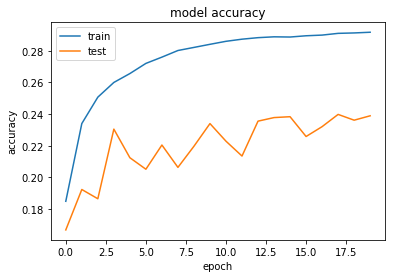

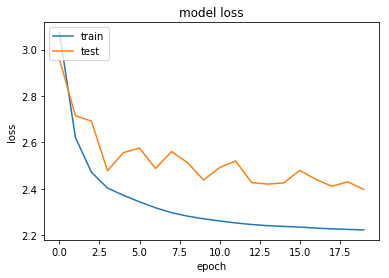

In [237]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()